# Ejercicio 12: Multimodal Embeddings

## Objetivo de la práctica

El objetivo de este ejercicio es observar cómo modelos multimodales como CLIP llevan texto e imágenes al mismo espacio vectorial, y verificar graficando embeddings en 2D.

### Pasos:

1. Obtener embeddings de imágenes y textos con CLIP.
2. Mostrar que ambos viven en el mismo espacio (misma dimensión y comparables).
3. Proyectar los vectores a 2D (PCA / t-SNE / UMAP) y graficarlos en un plano.
4. Verificar emparejamientos usando cosine similarity (búsqueda texto→imagen e imagen→texto).

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.metrics.pairwise import cosine_similarity
from transformers import CLIPProcessor, CLIPModel

import glob
import os

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)
print("Dispositivo:", device)

Dispositivo: cuda


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# CARGAR MODELO CLIP
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

In [ ]:
# 1. CARGAR IMÁGENES
CARPETA_IMAGENES = "/content/drive/MyDrive/RI/RI"

rutas_imagenes = sorted(glob.glob(os.path.join(CARPETA_IMAGENES, "*.jpg")))
imagenes = [Image.open(ruta).convert("RGB") for ruta in rutas_imagenes]

print(f"Imágenes cargadas: {len(imagenes)}")

Imágenes cargadas: 18


In [ ]:
# 2. PREPROCESAR IMÁGENES PARA CLIP
imagenes = [
    Image.open(p).convert("RGB")
    for p in rutas_imagenes
]


In [ ]:
# 3. OBTENER EMBEDDINGS DE IMÁGENES
inputs = processor(images=imagenes, return_tensors="pt")

with torch.no_grad():
    emb_imagenes = model.get_image_features(**inputs)

# Normalizar embeddings (norma = 1)
emb_imagenes = emb_imagenes / emb_imagenes.norm(dim=-1, keepdim=True)

# Pasar a numpy (para PCA, t-SNE, cosine similarity)
emb_imagenes = emb_imagenes.numpy()

print("Embeddings de imágenes:", emb_imagenes.shape)

Embeddings de imágenes: (18, 512)


In [ ]:
texts = [
    "dog",
    "cat",
    "car",
    "bike",
    "person ",
    "bed"
]

inputs = processor(text=texts, return_tensors="pt", padding=True)

with torch.no_grad():
    emb_textos = model.get_text_features(**inputs)

# Normalizar embeddings
emb_textos = emb_textos / emb_textos.norm(dim=-1, keepdim=True)

# Pasar a numpy (para PCA, t-SNE, cosine similarity)
emb_textos = emb_textos.numpy()

print("Embeddings de texto:", emb_textos.shape)

Embeddings de texto: (6, 512)


In [ ]:
print("Dimensión imagen:", emb_imagenes.shape[1])
print("Dimensión texto:", emb_textos.shape[1])


Dimensión imagen: 512
Dimensión texto: 512


In [ ]:
similarity = cosine_similarity(
    emb_textos,
    emb_imagenes
)

similarity


array([[0.193544  , 0.23215818, 0.18649913, 0.18125743, 0.1716602 ,
        0.182915  , 0.16404256, 0.18390357, 0.17801674, 0.21699588,
        0.2167106 , 0.2495197 , 0.2877388 , 0.2785066 , 0.2723016 ,
        0.19663449, 0.19241713, 0.19128099],
       [0.18489261, 0.22045943, 0.18516335, 0.16449381, 0.16310164,
        0.1725261 , 0.16086186, 0.18437275, 0.16919914, 0.2665452 ,
        0.26340598, 0.29387093, 0.20104364, 0.1955363 , 0.19781567,
        0.17533208, 0.18872222, 0.19227028],
       [0.17710379, 0.20577346, 0.2547595 , 0.20824909, 0.19831875,
        0.2192359 , 0.25732583, 0.2590043 , 0.25836527, 0.19256012,
        0.18882322, 0.22944944, 0.20223512, 0.19556196, 0.19242677,
        0.1983814 , 0.20434591, 0.19609235],
       [0.14347276, 0.17904873, 0.17758971, 0.26665872, 0.25988036,
        0.2714467 , 0.15524347, 0.17266533, 0.17636229, 0.16636238,
        0.16871354, 0.20667854, 0.18085353, 0.17145628, 0.17118707,
        0.17384864, 0.19550616, 0.16892597],
    

In [ ]:
# UNIR EMBEDDINGS (imagen + texto)
all_embeddings = np.vstack([emb_imagenes, emb_textos])

# PCA 2D
pca = PCA(n_components=2)
embeddings_2d_pca = pca.fit_transform(all_embeddings)

img_2d_pca = embeddings_2d_pca[:len(emb_imagenes)]
txt_2d_pca = embeddings_2d_pca[len(emb_imagenes):]

# t-SNE 2D
tsne = TSNE(n_components=2, perplexity=12, random_state=42)
embeddings_2d_tsne = tsne.fit_transform(all_embeddings)

img_2d_tsne = embeddings_2d_tsne[:len(emb_imagenes)]
txt_2d_tsne = embeddings_2d_tsne[len(emb_imagenes):]

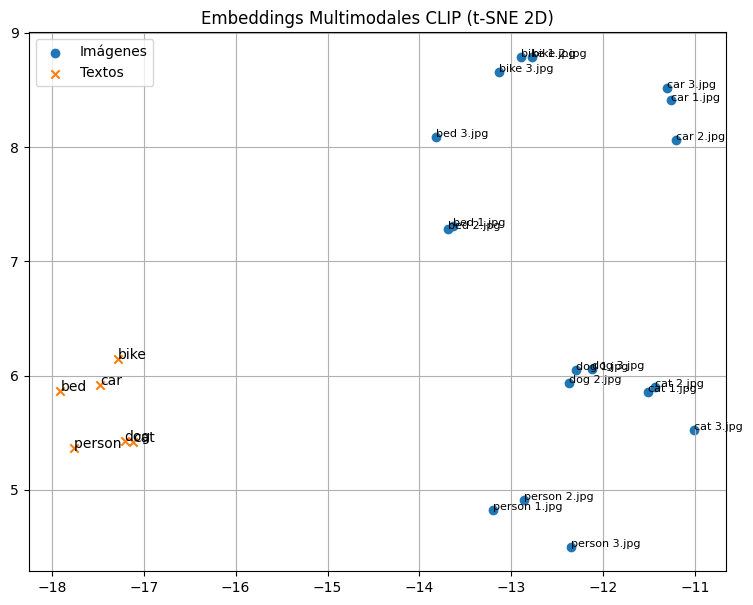

In [ ]:
plt.figure(figsize=(9,7))

plt.scatter(img_2d_tsne[:, 0], img_2d_tsne[:, 1], marker='o', label='Imágenes')
for i, name in enumerate(rutas_imagenes):
    plt.text(
        img_2d_tsne[i, 0],
        img_2d_tsne[i, 1],
        os.path.basename(name),
        fontsize=8
    )

plt.scatter(txt_2d_tsne[:, 0], txt_2d_tsne[:, 1], marker='x', label='Textos')
for i, txt in enumerate(texts):
    plt.text(
        txt_2d_tsne[i, 0],
        txt_2d_tsne[i, 1],
        txt,
        fontsize=10
    )

plt.title("Embeddings Multimodales CLIP (t-SNE 2D)")
plt.legend()
plt.grid(True)
plt.show()


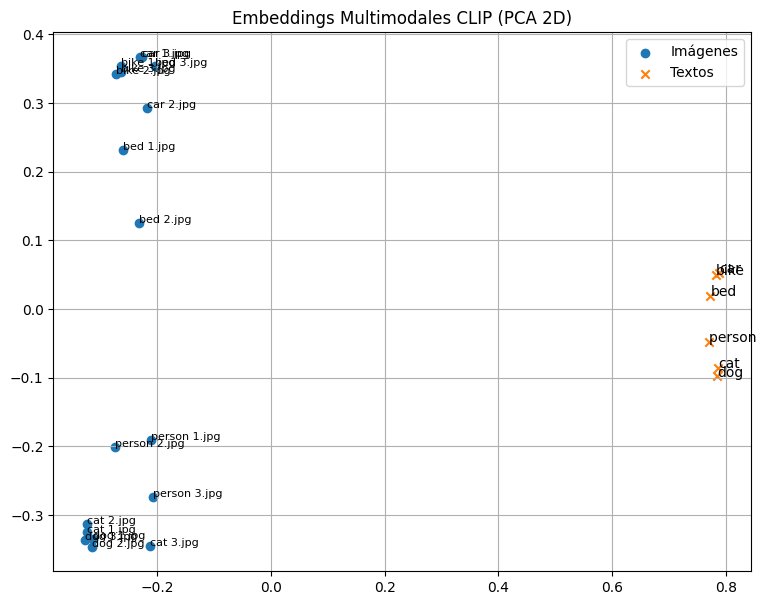

In [ ]:
plt.figure(figsize=(9,7))

plt.scatter(img_2d_pca[:, 0], img_2d_pca[:, 1], marker='o', label='Imágenes')
for i, name in enumerate(rutas_imagenes):
    plt.text(
        img_2d_pca[i, 0],
        img_2d_pca[i, 1],
        os.path.basename(name),
        fontsize=8
    )

plt.scatter(txt_2d_pca[:, 0], txt_2d_pca[:, 1], marker='x', label='Textos')
for i, txt in enumerate(texts):
    plt.text(
        txt_2d_pca[i, 0],
        txt_2d_pca[i, 1],
        txt,
        fontsize=10
    )

plt.title("Embeddings Multimodales CLIP (PCA 2D)")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
def buscar_imagen(texto):
    # Embedding del texto
    inputs = processor(text=[texto], return_tensors="pt", padding=True)
    with torch.no_grad():
        emb_texto = model.get_text_features(**inputs)

    # Normalizar
    emb_texto = emb_texto / emb_texto.norm(dim=-1, keepdim=True)
    emb_texto = emb_texto.numpy()

    # Similaridad coseno texto → imágenes
    scores = cosine_similarity(
        emb_texto,
        emb_imagenes
    )[0]

    idx = np.argmax(scores)

    print("Texto:", texto)
    print("Imagen más similar:", os.path.basename(rutas_imagenes[idx]))
    print("Score:", scores[idx])

    # Mostrar imagen
    img = Image.open(rutas_imagenes[idx])
    plt.imshow(img)
    plt.axis("off")
    plt.show()


In [ ]:
def buscar_texto(nombre_imagen):
    # Cargar imagen
    image = Image.open(nombre_imagen).convert("RGB")

    # Embedding de la imagen
    inputs = processor(images=image, return_tensors="pt")
    with torch.no_grad():
        emb_imagen = model.get_image_features(**inputs)

    # Normalizar
    emb_imagen = emb_imagen / emb_imagen.norm(dim=-1, keepdim=True)
    emb_imagen = emb_imagen.numpy()

    # Similaridad coseno imagen → textos
    scores = cosine_similarity(
        emb_imagen,
        emb_textos
    )[0]

    # Mostrar scores ordenados
    text_scores = sorted(zip(texts, scores), key=lambda x: x[1], reverse=True)
    print("Scores texto:")
    for t, s in text_scores:
        print(f"{t:35s} -> {s:.4f}")

    idx = np.argmax(scores)

    print("\nImagen:", os.path.basename(nombre_imagen))
    print("Texto más cercano:", texts[idx])

    plt.imshow(image)
    plt.axis("off")
    plt.show()


Texto: person 2
Imagen más similar: person 2.jpg
Score: 0.24466231


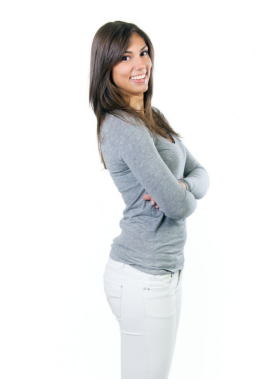

In [ ]:
buscar_imagen("person 2")

Scores texto:
person                              -> 0.2260
car                                 -> 0.1984
dog                                 -> 0.1966
bed                                 -> 0.1866
cat                                 -> 0.1753
bike                                -> 0.1738

Imagen: person 1.jpg
Texto más cercano: person 


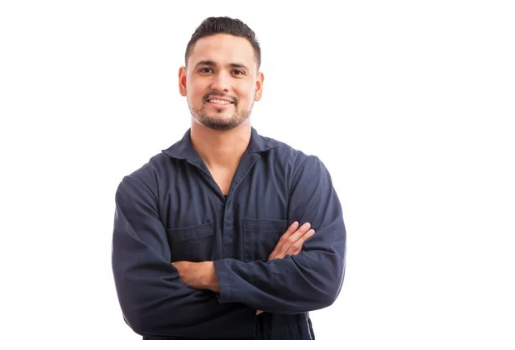

In [ ]:
buscar_texto("/content/drive/MyDrive/RI/RI/person 1.jpg")